In [4]:
import sys
sys.path.append('../..')

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.pyplot import imshow
from tqdm import tqdm
import torch
from torch.nn import Module
from torchsummary import summary

from collections import namedtuple, defaultdict
from pathlib import Path
import time

%matplotlib inline
rcParams['figure.figsize'] = (10, 15)

In [30]:
from src.constructor.config_structure import TrainConfigParams
from src.registry import TASKS
from src.constructor.data import create_dataset
from src.constructor.trainer import download_s3_artifact
from train import load_config

In [31]:
def load_hparams(config_path):
    hparams = load_config(config_path)
    hparams = TrainConfigParams(**hparams)
    
    return hparams

In [32]:
config_path = '../configs/strawberry_cls.yml'
config = load_hparams(config_path)

In [33]:
# Prevent XBM from loading
config.task.params['xbm_params'] = None

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [35]:
checkpoint = torch.load(download_s3_artifact('s3://sagemaker-mlflow-main/mlruns/3f2039f073e94c07b2f051e93bd3ef4a/artifacts/2-236.ckpt', '/tmp'), map_location=device)
# checkpoint = torch.load('local.ckpt')
model = TASKS.get(config.task.name)(config)
model = model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval();

Pretrained weights for efficientnet_b0 will be downloaded


In [36]:
model

MultiHeadClassificationTask(
  (criterion): JointLoss(
    (losses): ModuleList(
      (0): CrossEntropyLoss()
      (1): MSELoss()
    )
  )
  (backbone): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): SiLU(inplace=True)
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): SiLU(inplace=True)
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (conv_pw): Conv2d(32, 16, kernel_size=(1

In [37]:
import pandas as pd
import cv2 
import numpy as np

In [38]:
valid_df = pd.read_csv('/workdir/strawberry_hack/valid.csv')
valid_df

,label,image_path,healthy
0,8,initial/4195CB8C-84E6-4666-BCD8-AB84A557A01D_1...,0.85
1,4,initial/59CF77BC-FD03-42D8-AFEC-0D4980E49F24_1...,1.00
2,8,initial/5AAF624A-D095-4FD3-BE1A-E758E996E458_1...,1.00
3,5,initial/5B7A8144-C44E-4FE8-B0A7-1A716104D9B8_1...,1.00
4,4,initial/7B5A19D5-EB4B-408B-9636-697E63DAC47B_1...,1.00
...,...,...,...
60,1,initial/IMG_20210307_160355 524.jpg,0.90
61,1,initial/IMG_20210307_160600 522.jpg,1.00
62,1,initial/IMG_20210307_161218 416.jpg,1.00
63,1,initial/IMG_20210307_161447 413.jpg,1.00


In [96]:
from torchvision.transforms import ToTensor, Normalize, Compose, Resize

transforms = Compose([
        ToTensor(),
        Resize((512, 512)),
        # Normalize(0.37154224, 0.20088126),
        Normalize(mean =  [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        ])

main_path = '/workdir/strawberry_hack/'

label2class = {
    0: 'начало роста',
    1: 'появл. пер. 2-4 лист.',
    2: 'появл. цвет.',
    3: 'полный в. цвет.',
    4: 'цветение',
    5: 'опадение лепестков',
    6: 'формирование ягод',
    7: 'развитие плода',
    8: 'диффер. почек и усов'
}

for i in range(len(valid_df)):
        img_path = valid_df['image_path'][i]
        origin_img = cv2.imread(main_path + img_path)
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
        x = torch.unsqueeze(transforms(origin_img), 0).to(device)
        answer = model(x)
        class_index = int(torch.argmax(model.heads.classification(answer)))
        healthy = float(model.heads.regression(answer).cpu().detach()[0][0])
        
        font = cv2.FONT_HERSHEY_COMPLEX
        font_scale = 1
        color = (255, 255, 255, 1)
        thickness = 2

        origin_img = cv2.resize(origin_img, (512, 512))
        origin_img = cv2.cvtColor(origin_img, cv2.COLOR_RGB2BGR)
        
        origin_img[-50:, :, :] = 0 
        text = f'{label2class[class_index]}'
        origin_img = cv2.putText(origin_img, text, (10, 487), font, 
                        font_scale, color, thickness, cv2.LINE_AA)

        # healthy = 100*round(healthy, 2) 
        # if healthy > 100:
        #         healthy = 100
        # text = f'Процент здоровья: {healthy} %'
        # origin_img = cv2.putText(origin_img, text, (10, 100), font, 
        #                 font_scale, color, thickness, cv2.LINE_AA)
        
        cv2.imwrite('/workdir/strawberry_hack/results/' + img_path.split('/')[-1], origin_img)


In [51]:
class_index = int(torch.argmax(model.heads.classification(answer)))
healthy = float(model.heads.regression(answer).cpu().detach()[0][0])
class_index, healthy

(8, 0.9081810712814331)

In [56]:
from typing import Tuple
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont


# define decorator
def init_parameters(fun, **init_dict):
    """
    help you to set the parameters in one's habits
    """
    def job(*args, **option):
        option.update(init_dict)
        return fun(*args, **option)
    return job


def cv2_img_add_text(img, text, left_corner: Tuple[int, int],
                     text_rgb_color=(255, 0, 0), text_size=24, font='mingliu.ttc', **option):
    """
    USAGE:
        cv2_img_add_text(img, '中文', (0, 0), text_rgb_color=(0, 255, 0), text_size=12, font='mingliu.ttc')
    """
    pil_img = img
    if isinstance(pil_img, np.ndarray):
        pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(pil_img)
    font_text = ImageFont.load_default()
    # font_text = ImageFont.truetype(font=font, size=text_size, encoding=option.get('encoding', 'utf-8'))
    draw.text(left_corner, text, text_rgb_color, font=font_text)
    cv2_img = cv2.cvtColor(np.asarray(pil_img), cv2.COLOR_RGB2BGR)
    if option.get('replace'):
        img[:] = cv2_img[:]
        return None
    return cv2_img

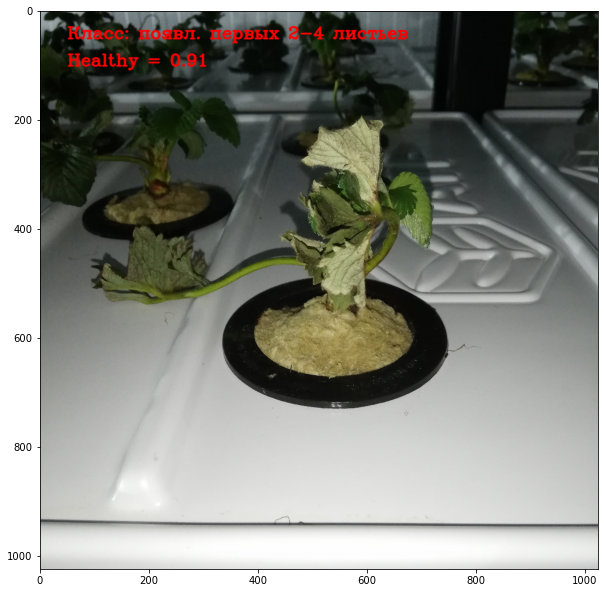

In [78]:
plt.imshow(origin_img)
font = cv2.FONT_HERSHEY_SIMPLEX
  
label2class = {
    0: 'начало роста',
    1: 'появл. первых 2-4 листьев',
    2: 'появл. цветоносов',
    3: 'полный выход цветоносов',
    4: 'цветение',
    5: 'опадение лепестков',
    6: 'формирование ягод',
    7: 'развитие плода',
    8: 'диффер. почек и усов'
}
# org
font = cv2.FONT_HERSHEY_COMPLEX
font_scale = 2
color = (255, 0, 0, 1)
thickness = 2

origin_img = cv2.imread(main_path + img_path)
origin_img = cv2.cvtColor(origin_img, cv2.COLOR_BGR2RGB)
origin_img = cv2.resize(origin_img, (1024, 1024))

text = f'Класс: {label2class[class_index]}'
   
image = cv2.putText(origin_img, text, (50, 50), font, 
                   fontScale, color, thickness, cv2.LINE_AA)
                   
image = cv2.putText(origin_img, 'Healthy = ' + str(round(healthy, 2)), (50, 100), font, 
                   fontScale, color, thickness, cv2.LINE_AA)
plt.imshow(image)

In [ ]:
for i in range(len(valid_df)):
    

In [9]:
traced = torch.jit.trace(model.forward, torch.rand(4, 3, 224, 224, device=device))

../src/models/backbones/resnet.py:597: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.size(1) == self.encoder_channels[i]:


In [10]:
traced.save('/mnt/ext1/fips-benchmark/models/siloiz_contrastive_xbm_resnet50_adam_512d.pt')